In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    """Simple double convolution block with normalization and activation"""
    
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.InstanceNorm2d(out_ch, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.InstanceNorm2d(out_ch, affine=True),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class SimpleUNet(nn.Module):
    """Simplified U-Net for bead classification"""
    
    def __init__(self, n_classes=4):
        super().__init__()
        self.n_classes = n_classes
        
        # Encoder (downsampling)
        self.enc1 = ConvBlock(3, 32)
        self.enc2 = ConvBlock(32, 64)
        self.enc3 = ConvBlock(64, 128)
        
        # Bottleneck
        self.bottleneck = ConvBlock(128, 256)
        
        # Decoder (upsampling)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = ConvBlock(256, 128)
        
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = ConvBlock(128, 64)
        
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = ConvBlock(64, 32)
        
        # Final layer
        self.final = nn.Conv2d(32, n_classes, 1)
        self.dropout = nn.Dropout2d(0.2)
        
        # Pooling
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        
        # Bottleneck
        b = self.bottleneck(self.pool(e3))
        b = self.dropout(b)
        
        # Decoder with skip connections
        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        # Final output
        out = self.final(d1)
        return out


# Example usage
if __name__ == "__main__":
    # Create simplified model
    model = SimpleUNet(n_classes=4)  # 10 bead classes
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Test with sample input
    x = torch.randn(2, 3, 256, 256)  # batch_size=2, channels=3, height=256, width=256
    
    model.eval()
    with torch.no_grad():
        output = model(x)
        predictions = torch.argmax(output, dim=1)
    
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Predictions shape: {predictions.shape}")
    
    # Training example
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    # Dummy training step
    target = torch.randint(0, 4, (2, 256, 256))
    
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    
    print(f"Training loss: {loss.item():.4f}")
    
    print("\nSimplified U-Net Features:")
    print("- 3 encoder/decoder levels (vs 4 in full U-Net)")
    print("- Fewer channels: 32→64→128→256 (vs 64→128→256→512→1024)")
    print("- Instance normalization for small datasets")
    print("- Simple skip connections")
    print("- Dropout for regularization")
    print("- ~10x fewer parameters than full U-Net")

Model parameters: 1,927,108
Input shape: torch.Size([2, 3, 256, 256])
Output shape: torch.Size([2, 4, 256, 256])
Predictions shape: torch.Size([2, 256, 256])
Training loss: 1.4498

Simplified U-Net Features:
- 3 encoder/decoder levels (vs 4 in full U-Net)
- Fewer channels: 32→64→128→256 (vs 64→128→256→512→1024)
- Instance normalization for small datasets
- Simple skip connections
- Dropout for regularization
- ~10x fewer parameters than full U-Net


Dataset: 9 samples | Train: 6 | Val: 1 | Test: 2
Training Config:
  Device: cuda
  Model parameters: 1,927,108
  Epochs: 500
  GPU Memory: 15.9 GB
  Classes: 4
------------------------------------------------------------
Epoch    1/500 | Train L: 0.0111 D: 0.2486 | Val L: 0.0328 D: 0.2459 | Time: 0.4s [BEST]
Epoch    2/500 | Train L: 0.0317 D: 0.2461 | Val L: 0.0122 D: 0.2485 | Time: 0.3s [BEST]
Epoch    8/500 | Train L: 0.0126 D: 0.2484 | Val L: 0.0117 D: 0.2485 | Time: 0.3s [BEST]
Epoch    9/500 | Train L: 0.0119 D: 0.2485 | Val L: 0.0112 D: 0.2486 | Time: 0.2s [BEST]
Epoch   10/500 | Train L: 0.0111 D: 0.2486 | Val L: 0.0108 D: 0.2487 | Time: 0.2s [BEST]
Epoch   11/500 | Train L: 0.0106 D: 0.2487 | Val L: 0.0103 D: 0.2487 | Time: 0.2s [BEST]
Epoch   12/500 | Train L: 0.0103 D: 0.2487 | Val L: 0.0098 D: 0.2488 | Time: 0.3s [BEST]
Epoch   13/500 | Train L: 0.0100 D: 0.2488 | Val L: 0.0092 D: 0.2488 | Time: 0.2s [BEST]
Epoch   14/500 | Train L: 0.0093 D: 0.2488 | Val L: 0.0087 D: 0.248

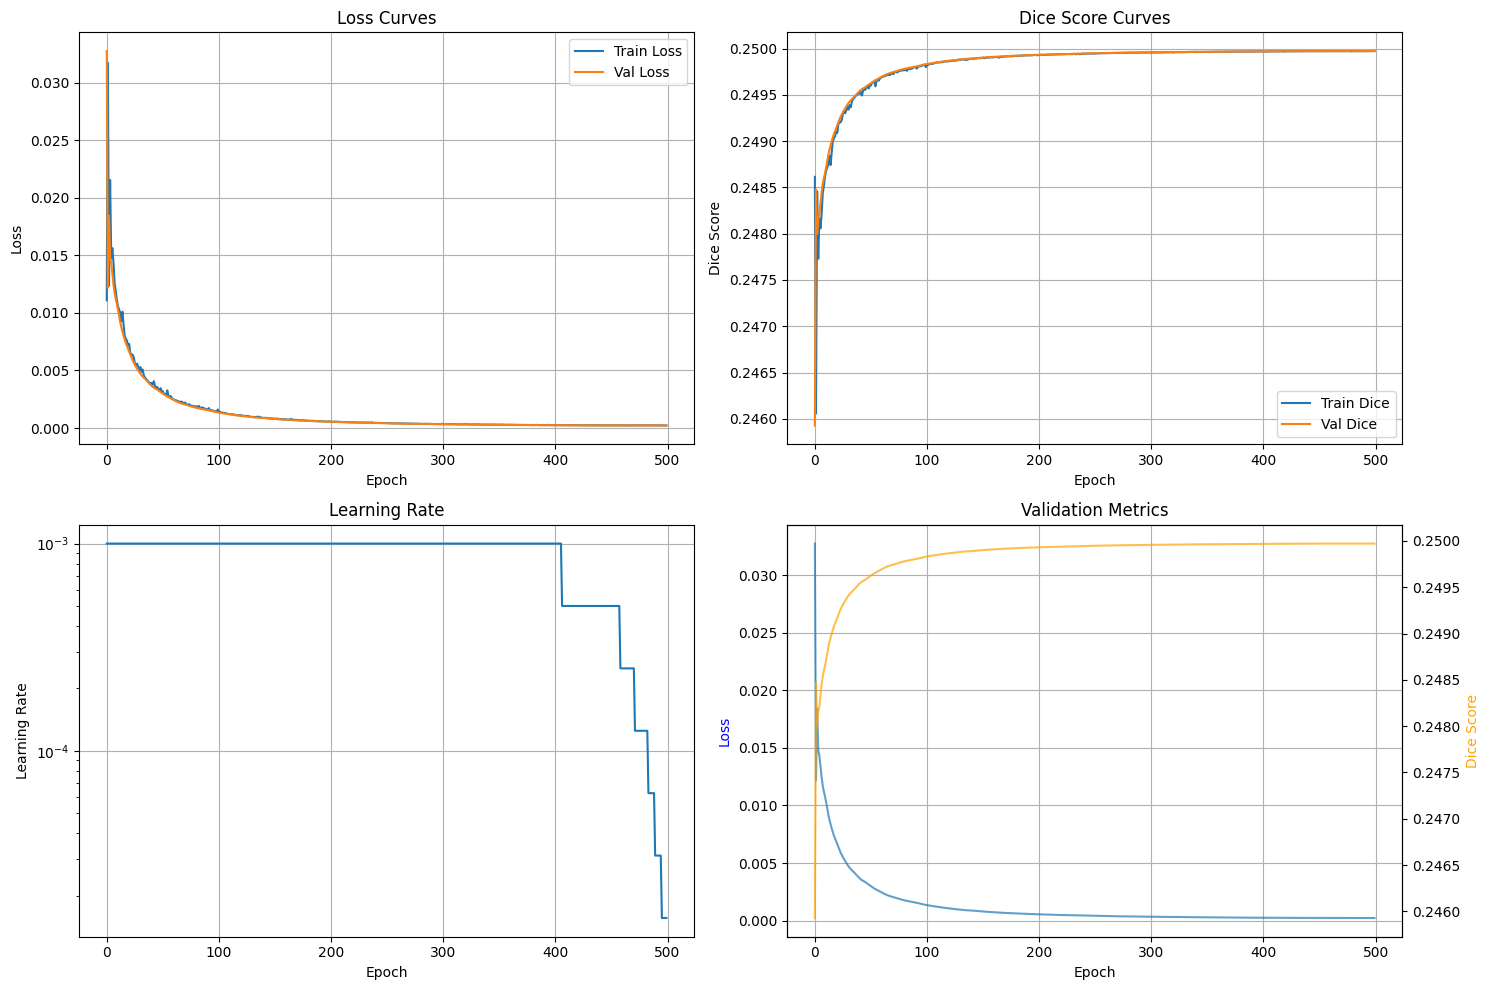

Evaluating: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    131072

    accuracy                           1.00    131072
   macro avg       1.00      1.00      1.00    131072
weighted avg       1.00      1.00      1.00    131072




C:\Users\Admins\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


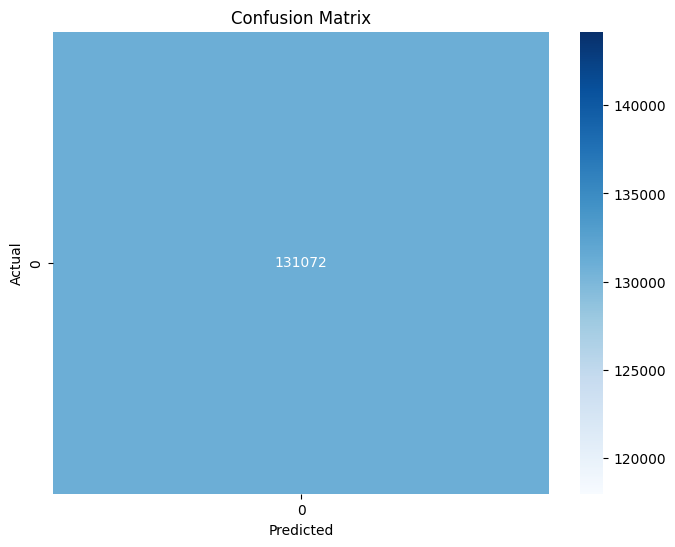

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from PIL import Image
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from collections import defaultdict
import time
import random


class BeadDataset(Dataset):
    """Custom dataset for bead segmentation"""
    
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform
        
        # Get all image files
        self.images = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        # Handle mask file extension - try same extension as image first
        mask_path = os.path.join(self.mask_dir, img_name)  # Same extension as image
        if not os.path.exists(mask_path):
            # Try different common extensions
            base_name = os.path.splitext(img_name)[0]  # Remove extension
            for ext in ['.png', '.jpg', '.jpeg']:
                mask_path = os.path.join(self.mask_dir, base_name + ext)
                if os.path.exists(mask_path):
                    break
        
        # Load image and mask
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Grayscale mask
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)
        
        return image, mask


class DiceScore(nn.Module):
    """Dice coefficient for segmentation evaluation"""
    
    def __init__(self, num_classes, smooth=1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        dice_scores = []
        
        for i in range(self.num_classes):
            pred_i = pred[:, i]
            target_i = (target == i).float()
            
            intersection = (pred_i * target_i).sum()
            union = pred_i.sum() + target_i.sum()
            
            dice = (2 * intersection + self.smooth) / (union + self.smooth)
            dice_scores.append(dice)
        
        return torch.stack(dice_scores).mean()


class SqueezeToLong:
    """Custom transform to replace lambda for multiprocessing compatibility"""
    def __call__(self, x):
        return x.squeeze().long()


class SegmentationTrainer:
    """Complete training pipeline for SimpleUNet"""
    
    def __init__(self, model, device, train_loader, val_loader, n_classes=4):
        self.model = model.to(device)
        self.device = device
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.n_classes = n_classes
        
        # Ensure model uses GPU efficiently
        if torch.cuda.is_available():
            self.model = self.model.cuda()
            if torch.cuda.device_count() > 1:
                self.model = nn.DataParallel(self.model)
        
        # Loss functions
        self.criterion = nn.CrossEntropyLoss()
        self.dice_metric = DiceScore(n_classes)
        
        # Optimizer and scheduler
        self.optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=1e-3, 
            weight_decay=1e-4
        )
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, 
            mode='min', 
            factor=0.5, 
            patience=5
        )
        
        # Training history
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_dice': [],
            'val_dice': [],
            'lr': []
        }
        
        # Best model tracking
        self.best_dice = 0.0
        self.best_model_state = None
        
        # Track scheduler events
        self.previous_lr = self.optimizer.param_groups[0]['lr']
    
    def train_epoch(self):
        """Train for one epoch with minimal output"""
        self.model.train() 
        running_loss = 0.0
        running_dice = 0.0
        
        # Use tqdm without description for cleaner output
        for batch_idx, (data, target) in enumerate(self.train_loader):
            data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
            
            # Forward pass
            self.optimizer.zero_grad()
            output = self.model(data)
            
            # Calculate loss
            loss = self.criterion(output, target)
            dice = self.dice_metric(output, target)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            # Update metrics
            running_loss += loss.item()
            running_dice += dice.item()
        
        avg_loss = running_loss / len(self.train_loader)
        avg_dice = running_dice / len(self.train_loader)
        
        return avg_loss, avg_dice
    
    def validate(self):
        """Validate the model with minimal output"""
        self.model.eval()
        running_loss = 0.0
        running_dice = 0.0
        
        with torch.no_grad():
            for data, target in self.val_loader:
                data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                
                output = self.model(data)
                loss = self.criterion(output, target)
                dice = self.dice_metric(output, target)
                
                running_loss += loss.item()
                running_dice += dice.item()
        
        avg_loss = running_loss / len(self.val_loader)
        avg_dice = running_dice / len(self.val_loader)
        
        return avg_loss, avg_dice
    
    def train(self, num_epochs, save_dir='checkpoints', print_every=10):
        """Full training loop with compact output"""
        os.makedirs(save_dir, exist_ok=True)
        
        print(f"Training Config:")
        print(f"  Device: {self.device}")
        print(f"  Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print(f"  Epochs: {num_epochs}")
        print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB" if torch.cuda.is_available() else "")
        print(f"  Classes: {self.n_classes}")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            epoch_start = time.time()
            
            # Training phase
            train_loss, train_dice = self.train_epoch()
            
            # Validation phase
            val_loss, val_dice = self.validate()
            
            # Update learning rate
            self.scheduler.step(val_loss)
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Check for LR reduction
            lr_reduced = current_lr != self.previous_lr
            if lr_reduced:
                self.previous_lr = current_lr
            
            # Save metrics
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_dice'].append(train_dice)
            self.history['val_dice'].append(val_dice)
            self.history['lr'].append(current_lr)
            
            # Save best model
            is_best = val_dice > self.best_dice
            if is_best:
                self.best_dice = val_dice
                self.best_model_state = self.model.state_dict().copy()
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'best_dice': self.best_dice,
                    'history': self.history
                }, os.path.join(save_dir, 'best_model.pth'))
            
            # Regular checkpoint
            if (epoch + 1) % 100 == 0:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'history': self.history
                }, os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth'))
            
            # Compact printing
            if (epoch + 1) % print_every == 0 or epoch == 0 or is_best or lr_reduced:
                epoch_time = time.time() - epoch_start
                status = ""
                if is_best:
                    status += " [BEST]"
                if lr_reduced:
                    status += f" [LR: {current_lr:.6f}]"
                
                print(f"Epoch {epoch+1:4d}/{num_epochs} | "
                      f"Train L: {train_loss:.4f} D: {train_dice:.4f} | "
                      f"Val L: {val_loss:.4f} D: {val_dice:.4f} | "
                      f"Time: {epoch_time:.1f}s{status}")
        
        total_time = time.time() - start_time
        print("-" * 60)
        print(f"Training completed in {total_time/60:.1f} minutes")
        print(f"Best validation Dice: {self.best_dice:.4f}")
        
        # Load best model
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
            print("Best model loaded.")
    
    def plot_training_history(self):
        """Plot training curves"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss curves
        axes[0, 0].plot(self.history['train_loss'], label='Train Loss')
        axes[0, 0].plot(self.history['val_loss'], label='Val Loss')
        axes[0, 0].set_title('Loss Curves')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Dice curves
        axes[0, 1].plot(self.history['train_dice'], label='Train Dice')
        axes[0, 1].plot(self.history['val_dice'], label='Val Dice')
        axes[0, 1].set_title('Dice Score Curves')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Dice Score')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Learning rate
        axes[1, 0].plot(self.history['lr'])
        axes[1, 0].set_title('Learning Rate')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True)
        
        # Combined metrics
        axes[1, 1].plot(self.history['val_loss'], label='Val Loss', alpha=0.7)
        ax2 = axes[1, 1].twinx()
        ax2.plot(self.history['val_dice'], label='Val Dice', color='orange', alpha=0.7)
        axes[1, 1].set_title('Validation Metrics')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss', color='blue')
        ax2.set_ylabel('Dice Score', color='orange')
        axes[1, 1].grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def evaluate_model(self, test_loader):
        """Comprehensive model evaluation"""
        self.model.eval()
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            for data, target in tqdm(test_loader, desc='Evaluating'):
                data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                
                output = self.model(data)
                pred = torch.argmax(output, dim=1)
                
                all_predictions.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
        
        # Classification report
        print("\nClassification Report:")
        print(classification_report(all_targets, all_predictions))
        
        # Confusion matrix
        cm = confusion_matrix(all_targets, all_predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        return all_predictions, all_targets


def create_data_loaders(data_dir, batch_size=8, img_size=256, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, random_seed=42):
    """
    Create data loaders with automatic train/val/test split from a single directory
    Optimized for GPU training with pin_memory and non_blocking transfers
    """
    
    # Validate ratios
    if abs(train_ratio + val_ratio + test_ratio - 1.0) > 1e-6:
        raise ValueError("train_ratio + val_ratio + test_ratio must equal 1.0")
    
    # Set random seed for reproducibility
    random.seed(random_seed)
    
    # Data transforms
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        
        # Geometric augmentations
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=30, fill=0),  # Increased rotation range
        transforms.RandomAffine(
            degrees=15,
            translate=(0.1, 0.1),
            scale=(0.8, 1.2),
            shear=10,
            fill=0
        ),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        
        # Color augmentations
        transforms.ColorJitter(
            brightness=0.4,    # Increased brightness variation
            contrast=0.4,      # Increased contrast variation
            saturation=0.4,    # Increased saturation variation
            hue=0.2           # Increased hue variation
        ),
        transforms.RandomGrayscale(p=0.1),  # Randomly convert to grayscale
        
        # Additional augmentations
        transforms.RandomAutocontrast(p=0.3),  # Auto-adjust contrast
        transforms.RandomEqualize(p=0.3),      # Histogram equalization
        transforms.RandomPosterize(bits=4, p=0.2),  # Reduce color bits
        transforms.RandomSolarize(threshold=128, p=0.1),  # Solarization effect
        
        # Gaussian blur for noise robustness
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),
        
        # Convert to tensor and normalize
        transforms.ToTensor(),
        
        # Random noise injection
        transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.01),  # Add small Gaussian noise
        
        # Standard normalization
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    target_transform = transforms.Compose([
        transforms.Resize((img_size, img_size), interpolation=transforms.InterpolationMode.NEAREST),
        transforms.ToTensor(),
        SqueezeToLong()
    ])
    
    # Create full dataset
    full_dataset = BeadDataset(
        os.path.join(data_dir, 'images'),
        os.path.join(data_dir, 'masks'),
        transform=None,
        target_transform=target_transform
    )
    
    # Get total number of samples
    total_samples = len(full_dataset)
    
    # Calculate split sizes
    train_size = int(train_ratio * total_samples)
    val_size = int(val_ratio * total_samples)
    test_size = total_samples - train_size - val_size
    
    # Create indices for splitting
    indices = list(range(total_samples))
    
    # Split indices
    train_indices, temp_indices = train_test_split(
        indices, 
        train_size=train_size, 
        random_state=random_seed,
        shuffle=True
    )
    
    val_indices, test_indices = train_test_split(
        temp_indices,
        train_size=val_size,
        random_state=random_seed,
        shuffle=True
    )
    
    # Create datasets with different transforms
    train_dataset = BeadDataset(
        os.path.join(data_dir, 'images'),
        os.path.join(data_dir, 'masks'),
        transform=train_transform,
        target_transform=target_transform
    )
    
    val_dataset = BeadDataset(
        os.path.join(data_dir, 'images'),
        os.path.join(data_dir, 'masks'),
        transform=val_test_transform,
        target_transform=target_transform
    )
    
    test_dataset = BeadDataset(
        os.path.join(data_dir, 'images'),
        os.path.join(data_dir, 'masks'),
        transform=val_test_transform,
        target_transform=target_transform
    )
    
    # Create subsets using indices
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(val_dataset, val_indices)
    test_subset = Subset(test_dataset, test_indices)
    
    # Create data loaders - using 0 workers to avoid multiprocessing issues
    # You can increase num_workers if your environment supports it
    num_workers = 0  # Set to 0 to avoid pickle issues
    pin_memory = torch.cuda.is_available()
    
    train_loader = DataLoader(
        train_subset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    val_loader = DataLoader(
        val_subset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    test_loader = DataLoader(
        test_subset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    
    print(f"Dataset: {total_samples} samples | Train: {len(train_indices)} | Val: {len(val_indices)} | Test: {len(test_indices)}")
    
    return train_loader, val_loader, test_loader


def main():
    """Main training script optimized for GPU"""
    # Set device and optimize for GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # GPU optimizations
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True  # Optimize for fixed input sizes
        torch.backends.cudnn.deterministic = False  # Allow non-deterministic for speed
    
    # Create model - Note: You'll need to import or define SimpleUNet
    # from your_model_file import SimpleUNet
    # model = SimpleUNet(n_classes=4)
    
    # Create data loaders (adjust paths as needed)
    train_loader, val_loader, test_loader = create_data_loaders(
        data_dir='UNET_dataset',
        batch_size=16,  # Increased batch size for better GPU utilization
        img_size=256
    )
    
    # Create trainer
    trainer = SegmentationTrainer(
        model=model,
        device=device,
        train_loader=train_loader,
        val_loader=val_loader,
        n_classes=4
    )
    
    # Train model with compact output (print every 10 epochs)
    trainer.train(num_epochs=500, print_every=10)
    
    # Plot training history
    trainer.plot_training_history()
    
    # Evaluate on test set
    trainer.evaluate_model(test_loader)


if __name__ == "__main__":
    main()